In [1]:
import random
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.core.display as di

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score


In [2]:
random.seed(9001)
%matplotlib inline
color = sns.color_palette()
pd.options.mode.chained_assignment = None
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


In [3]:
# import dataset
df = pd.read_csv("20110810_preprocessing.txt")
df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,label
0,35213.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,0
1,35213.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,0
2,35213.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,0
3,35213.053771,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,0
4,35213.053937,3427.768066,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,0


## kmeans

In [4]:
def preprocessing(df):
    # remove in&out IP and StartTime
    df = df.drop(["label", "StartTime", "SrcAddr", "DstAddr"], axis = 1)
    # category 
    df.Proto = df.Proto.astype("category").cat.codes
    df.Sport = df.Sport.astype("category").cat.codes
    df.State = df.State.astype("category").cat.codes
    df.Dir = df.Dir.astype("category").cat.codes
    print ("shape of kmeans dataset :", df.shape)
    # StandardScaler
    sc = StandardScaler(copy=True, with_mean=True, with_std=True)
    Z = sc.fit_transform(df)
    return Z

In [5]:
Z = preprocessing(df)
pd.DataFrame(Z).head()

shape of kmeans dataset : (2824636, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,3.130995,0.265958,0.119758,0.524888,0.002088,-0.465649,-0.012527,-0.012827,-0.004314,-0.005733,-0.002014
1,-0.434010,0.265958,-0.455717,0.524888,0.002088,-0.465649,-0.012527,-0.012827,-0.007514,-0.005964,-0.002195
2,-0.434010,-0.533809,-1.867567,2.130956,-0.009654,-0.341373,-0.012527,-0.012827,-0.007514,-0.005968,-0.002204
3,-0.433953,-0.533809,-0.227973,2.130956,0.010914,-0.323620,-0.012527,-0.012827,-0.007194,-0.005950,-0.002171
4,3.008069,0.265958,-0.821714,0.524888,0.002088,-0.465649,-0.012527,-0.012827,0.005287,-0.005117,-0.001377


### kmeans

In [6]:
kmeans = KMeans(n_clusters = 2, random_state = 9001, algorithm = 'full', tol = 1e-7,
                precompute_distances = False)
kmeans.fit(Z)
y_kmeans = kmeans.predict(Z)

In [7]:
print ("distribution of label_kmeans :")
print (pd.DataFrame(y_kmeans, columns=["num"]).num.value_counts())

distribution of label_kmeans :
0    2197617
1     627019
Name: num, dtype: int64


### PCA (dimension reduction to 2)

In [8]:
def pca(Z):
    # variance and covariance matrix eigenvalues
    C = np.dot(Z.T, Z) / df.shape[0]
    eigen_vals, eigen_vecs = np.linalg.eigh(C)
    print('\nEigenvalues: \n%s' % eigen_vals)
    tot = sum(np.abs(eigen_vals))
    var_exp = [(i / tot) for i in sorted(np.abs(eigen_vals), reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    plt.bar(range(1, eigen_vals.size + 1), var_exp, alpha=0.5, align='center',
            label='Individual')
    plt.step(range(1, eigen_vals.size + 1), cum_var_exp, where='mid',
             label='Cumulative')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    # projection
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
    eigen_pairs.sort(reverse=True)

    P = np.hstack((eigen_pairs[0][1][:, np.newaxis],
                   eigen_pairs[1][1][:, np.newaxis]))
    Z_pca = Z.dot(P)
    return Z_pca

def pca_kmeans_plot(Z_pca, y_kmeans):
    result_pca = pd.DataFrame(np.hstack([Z_pca, y_kmeans.reshape(y_kmeans.shape[0], 1)]))
    result_pca.columns = ['pc1', 'pc2', "label_kmeans"]
    ### plot
    result_pca.plot.scatter(x='pc1', y='pc2', c='label_kmeans', s = 5, colormap='brg')
    return result_pca


In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Evaluation
def evaluation(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_ = auc(fpr, tpr)
    cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

    np.set_printoptions(precision=2)
    class_names = ["normal", "botnet"]

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names,
                          title = 'Confusion matrix, without normalization')
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names, normalize = True,
                          title = 'Normalized confusion matrix')
    print("------------------------------------")
    print("Baseline    : %.6f" % (1 - sum(y_true)/y_true.shape[0]))
    print("Accuracy    : %f" % accuracy_score(y_true, y_pred))
    print("Precision   : %f" % precision_score(y_true, y_pred))
    print("Recall      : %f" % recall_score(y_true, y_pred))
    print("F1-Score    : %f" % f1_score(y_true, y_pred))
    print("AUC         : %f" % auc_)
    plt.show()



Eigenvalues: 
[ 0.00937033  0.13727338  0.48353973  0.59712113  0.75273496  0.99843336
  0.99986166  1.0037676   1.2134941   2.29593479  2.50846895]


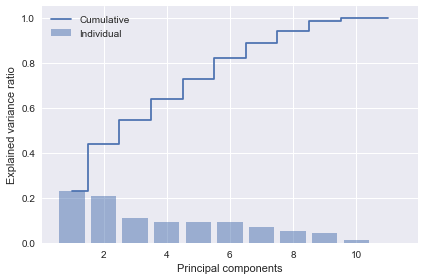

In [10]:
Z_pca = pca(Z)

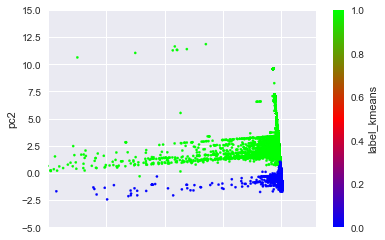

In [11]:
result_pca = pca_kmeans_plot(Z_pca, y_kmeans)
plt.xlim(-20, 3)
plt.ylim(-5, 15)
plt.show()

Confusion matrix, without normalization
[[2171471  612204]
 [  26146   14815]]
Normalized confusion matrix
[[ 0.78  0.22]
 [ 0.64  0.36]]
------------------------------------
Baseline    : 0.985499
Accuracy    : 0.774006
Precision   : 0.023628
Recall      : 0.361686
F1-Score    : 0.044358
AUC         : 0.570879


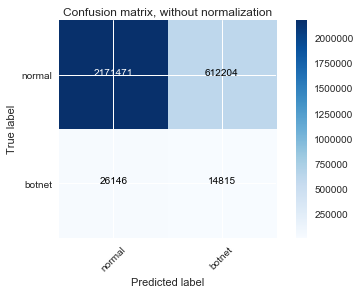

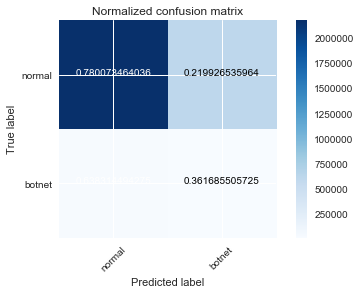

In [12]:
y_true = df["label"]
y_pred = result_pca["label_kmeans"]
evaluation(y_true, y_pred)

# Testing 

shape of kmeans dataset : (1808122, 11)

Eigenvalues: 
[ 0.01  0.08  0.43  0.45  0.49  0.64  0.65  0.65  0.76  1.41  1.49]


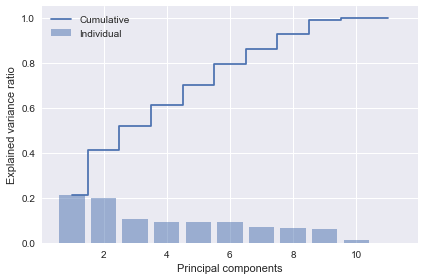

In [13]:
df_11 = pd.read_csv("20110811_preprocessing.txt")
Z = preprocessing(df_11)
y_kmeans = kmeans.predict(Z)
### pca plot
Z_pca = pca(Z)

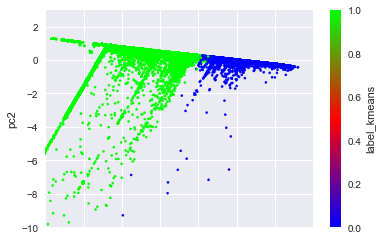

In [14]:
result_pca = pca_kmeans_plot(Z_pca, y_kmeans)
plt.xlim(-5, 2)
plt.ylim(-10, 3)
plt.show()

Confusion matrix, without normalization
[[1289339  497842]
 [    793   20148]]
Normalized confusion matrix
[[ 0.72  0.28]
 [ 0.04  0.96]]
------------------------------------
Baseline    : 0.988418
Accuracy    : 0.724225
Precision   : 0.038897
Recall      : 0.962132
F1-Score    : 0.074770
AUC         : 0.841784


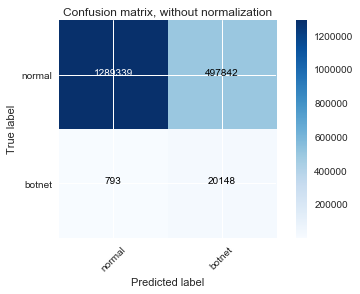

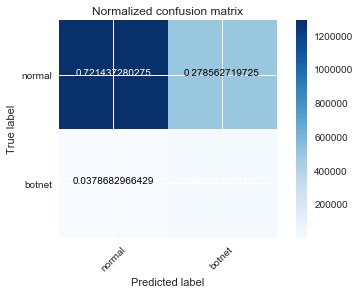

In [15]:
y_true = df_11["label"]
y_pred = result_pca["label_kmeans"]
evaluation(y_true, y_pred)

> 簡單來說，我利用前面處理好的資料，將時間、輸出IP位置和輸入IP位置移除，再來直接做kmeans分群。比較大群的為正常，比較小群的視為異常，在用真的資料的label去評斷結果。